## Technical Challenge

Este é um desafio para uma vaga de estágio na Ford, em que é pedido para criar um classifcador de imagens de trânsito e explicar tudo o que foi feito, o por quê foi feito e como foi feito, abaixo eu comento sobre os arquivos csv que fazem parte do conjunto de dados.

O Test.csv é um dataset com exemplos para o teste, ou seja, para validar o modelo de aprendizado e ver como ele está se saindo, possuindo o caminho das imagens, sua classificação, largura e altura, etc.

O Train.csv é um dataset com exemplos para o treinamento do modelo em questão, possuindo o caminho das imagens, sua classificação, largura e altura, etc.

O Meta.csv é um dataset possui o caminho das imagens que correspondem a tal classificação, por exemplo, o número 14 é o Stop, a imagem referente é a de uma placa de Stop.

O Labels.csv é um dataset com 43 entradas e duas colunas em que a coluna ClassId é a coluna das classificações e SignName é o que a placa quer dizer.

E temos as pastas com as imagens, temos três e são elas: Meta, Train e Test; Onde cada uma delas contém as imagens referentes ao nome das pastas, por exemplo, a pasta Train possui as imagens para o treinamento.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
test_df = pd.read_csv("./Test.csv")
meta_df = pd.read_csv("./Meta.csv")
train_df = pd.read_csv("./Train.csv")
labels_df = pd.read_csv("./Labels.csv")

## Data Exploration

In [3]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [5]:
meta_df.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [6]:
labels_df.head() 

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


Ordenei o test_df para poder plotar um exemplo.

In [7]:
test_df.sort_values(by=['ClassId'])

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
5945,49,51,6,5,44,46,0,Test/05945.png
7712,31,33,6,6,25,28,0,Test/07712.png
807,45,49,5,5,40,44,0,Test/00807.png
809,32,31,6,5,27,26,0,Test/00809.png
4512,31,34,5,5,26,29,0,Test/04512.png
...,...,...,...,...,...,...,...,...
4496,32,33,5,5,26,27,42,Test/04496.png
9593,27,28,6,5,22,23,42,Test/09593.png
11842,41,43,6,6,36,38,42,Test/11842.png
5786,49,53,6,5,44,48,42,Test/05786.png


In [8]:
img = cv.imread(test_df.loc[5945]['Path'])

In [9]:
img.shape[:2]

(51, 49)

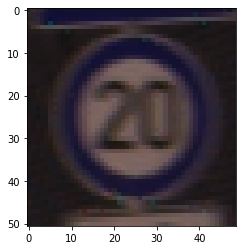

In [10]:
plt.imshow(img)

Aqui eu vejo a correlação para poder entender mais como as colunas se relacionam e assim ajudar na seleção dos atributos, no caso, vemos que largura e altura se corrolacionam entre si e com Roi.X1 em diante, e como não precisamos dessas informações, pois basta utilizar o .shape na matriz da imagem, é descartada na seleção.

<AxesSubplot:>

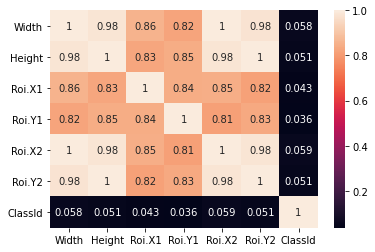

In [11]:
sns.heatmap(train_df.corr(), annot=True)

Vemos abaixo o desbalanceamento dos dados de treino e para resolver isto, podemos utilizar o oversampling para que todas as classes fiquem com o mesmo número de exemplos.

<AxesSubplot:xlabel='ClassId', ylabel='count'>

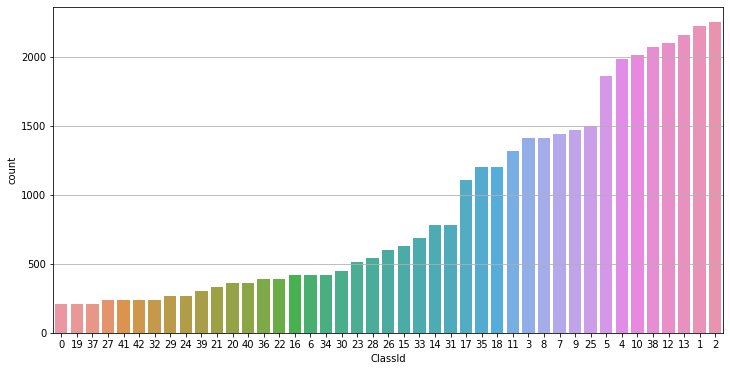

In [12]:
plt.figure(figsize=(12,6))
plt.grid()
sns.countplot(x='ClassId', data=train_df, order=train_df['ClassId'].value_counts(ascending=True).index)

E como vimos em cima, temos a mesma situação com os dados de teste.

<AxesSubplot:xlabel='ClassId', ylabel='count'>

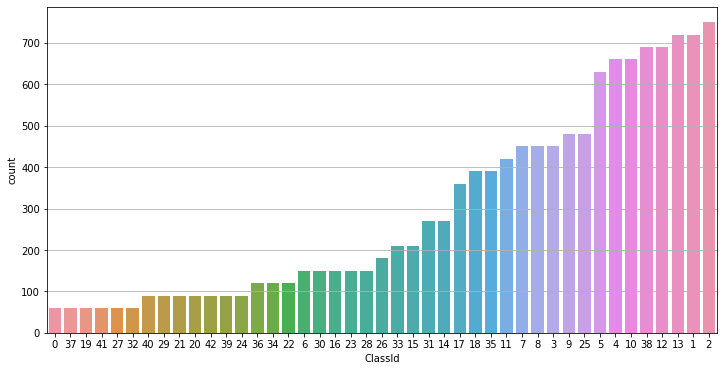

In [13]:
plt.figure(figsize=(12,6))
plt.grid()
sns.countplot(x='ClassId', data=test_df, order=test_df['ClassId'].value_counts(ascending=True).index)

Peguei uma imagem para ver como é a sua matriz e seu shape.

In [14]:
img = cv.imread("Train/20/00020_00000_00000.png")
img

array([[[ 56,  51,  46],
        [ 56,  51,  48],
        [ 54,  51,  50],
        ...,
        [ 49,  48,  50],
        [ 51,  50,  50],
        [ 49,  49,  46]],

       [[ 56,  51,  47],
        [ 54,  49,  47],
        [ 54,  50,  49],
        ...,
        [ 49,  49,  53],
        [ 55,  57,  57],
        [ 50,  50,  46]],

       [[ 56,  51,  48],
        [ 52,  48,  46],
        [ 52,  49,  47],
        ...,
        [ 53,  53,  59],
        [ 61,  64,  64],
        [ 53,  54,  48]],

       ...,

       [[ 55,  51,  47],
        [ 54,  51,  49],
        [ 54,  52,  52],
        ...,
        [ 61,  77,  89],
        [ 62,  80,  91],
        [ 49,  62,  73]],

       [[ 56,  53,  49],
        [ 59,  55,  53],
        [ 56,  53,  53],
        ...,
        [ 70,  94, 107],
        [ 66,  93,  99],
        [ 55,  73,  72]],

       [[ 55,  52,  51],
        [ 61,  55,  54],
        [ 58,  54,  53],
        ...,
        [ 80, 112, 116],
        [ 61,  98,  98],
        [ 62,  85,  80]]

In [15]:
img.shape

(26, 27, 3)

Aqui eu vejo como está a distribuição das larguras da imagem de treino, e temos uma média de quase 50, estou vendo essas duas coisas para poder fazer um resize em todas as imagens, pois para passar como entrada na rede neural, é necessário estar do mesmo tamanho.

<AxesSubplot:ylabel='Frequency'>

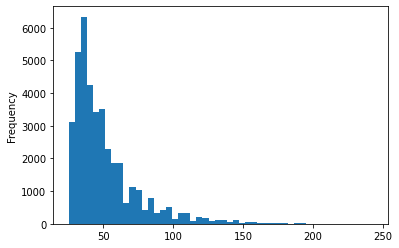

In [16]:
train_df['Width'].plot(kind='hist', bins=50)

In [17]:
train_df['Width'].mean()

50.83587951745773

E aqui eu vejo distribuição da altura das imagens.

<AxesSubplot:ylabel='Frequency'>

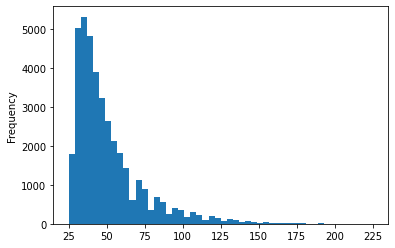

In [18]:
train_df['Height'].plot(kind='hist', bins=50)

In [19]:
train_df['Height'].mean()

50.328929582493814

Aqui eu faço um resize, para poder ver como fica a imagem após.

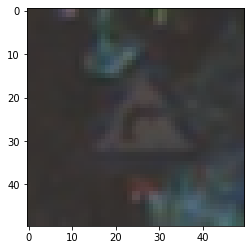

In [20]:
img = cv.resize(img,(50, 50), interpolation = cv.INTER_CUBIC)
plt.imshow(img)

Utilizo o info para ver se temos dados nulos.

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


## Data Transformation

Aqui eu aplico uma função do openCV para transformar a imagem numa matriz numérica e adiciono uma coluna com essas matrizes.

In [22]:
train_df['MatrixIMG'] = train_df['Path'].apply(lambda x: cv.imread(x))

In [23]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,MatrixIMG
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,"[[[56, 51, 46], [56, 51, 48], [54, 51, 50], [5..."
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,"[[[55, 50, 47], [55, 50, 49], [54, 50, 50], [5..."
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,"[[[57, 50, 51], [60, 51, 51], [57, 51, 50], [5..."
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,"[[[54, 49, 49], [55, 50, 49], [55, 50, 48], [5..."
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,"[[[55, 50, 50], [56, 50, 51], [54, 49, 51], [5..."


Após a transformação, eu faço um resize em todas as matrizes, para que fiquem do mesmo tamanho, (50,50).

In [24]:
train_df['MatrixIMG'] = train_df['MatrixIMG'].apply(lambda img: cv.resize(img,(50, 50), interpolation = cv.INTER_CUBIC))

Fiz uma função que transforma em escala de cinzas para que o shape (50,50,3) vá para (50,50).

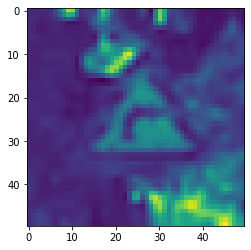

In [25]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

plt.imshow(rgb2gray(train_df['MatrixIMG'][0]))

In [26]:
train_df['MatrixIMG'][0].shape

(50, 50, 3)

In [27]:
rgb2gray(train_df['MatrixIMG'][0]).shape

(50, 50)

Assim, aplico a função para todas as imagens.

In [28]:
train_df['MatrixIMG'] = train_df['MatrixIMG'].apply(rgb2gray)

Após isso, normalizo todas as imagens, para que uma feature da imagem não se saia por cima de outra.

In [29]:
train_df['MatrixIMG'] = train_df['MatrixIMG'].apply(lambda x: x/255.0)

In [30]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,MatrixIMG
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,"[[0.2036054901960784, 0.2036054901960784, 0.20..."
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,"[[0.200578431372549, 0.20102549019607843, 0.20..."
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,"[[0.20353882352941174, 0.20588313725490195, 0...."
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,"[[0.197998431372549, 0.197998431372549, 0.2014..."
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,"[[0.20191960784313726, 0.20309176470588233, 0...."


## Model Selection

Para o modelo de aprendizado, preferi utilizar a rede convolucional, poís possuímos muitos dados mesmo que estejam desbanlanceados, pensei em utilizar o KNN mas iria ser custoso e tem o problema de que, se eu não mostrar nenhum exemplo de alguma classe, ele nunca acertará.

Utilizei a inicialização dos pesos em cada camada com a distribuição normal e um regularizador l1 para que meus pesos sejam baixos e implementei um early stopping para poder evitar o overfitting.

In [80]:
model = tf.keras.models.Sequential([
     
     tf.keras.layers.Conv2D(10, (5,5), padding='same', input_shape=(50,50,1), kernel_initializer="normal", activation='relu', 
                           kernel_regularizer=tf.keras.regularizers.l1(0.01)),
     
     tf.keras.layers.MaxPooling2D((2,2)),
     
     tf.keras.layers.Conv2D(15, (5,5), activation='relu', kernel_initializer="normal"),
     
     tf.keras.layers.MaxPooling2D((2,2)),
     tf.keras.layers.Flatten(),
     
     tf.keras.layers.Dense(100, activation='relu', kernel_initializer="normal"),
     tf.keras.layers.Dense(50, activation='relu', kernel_initializer="normal"),
     tf.keras.layers.Dense(43, activation='softmax')
  
 ])
       
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])     

callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=10, verbose=1, mode="auto") 

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 10)        260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 15)        3765      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 15)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1500)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               150100    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5

## Data Featuring

Utilizei apenas a coluna das matrizes das imagens para o treinamento, as outras colunas não são necessárias.

In [33]:
X_train = train_df['MatrixIMG']
y_train = train_df[['ClassId']].values

Coloquei cada exemplo em um array para poder utilizar o reshape, para colocar esse shape (X_train.shape[0], 50, 50, 1) , para podermos passar como entrada na rede.

In [34]:
exemplos = []

for i in range(len(X_train)):
    exemplos.append(X_train[i])

In [35]:
X_train = np.array(exemplos)

In [36]:
X_train = X_train.reshape((X_train.shape[0], 50, 50, 1))

In [37]:
X_train.shape

(39209, 50, 50, 1)

In [38]:
y_train.shape

(39209, 1)

Como temos um problema de classificação multiclasse, temos que utilizar o one hot encoder, para que a saída da rede neural seja uma probabilidade de ser de alguma classe, onde tem a maior probabilidade é colocada como 1, e para a função de custo, que necessita que seja utilizado o one hot encoder para problemas multiclasses.  

In [39]:
one_hot = OneHotEncoder(sparse=False)

In [40]:
y_train = one_hot.fit_transform(y_train)

In [41]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [45]:
history = model.fit(x=X_train, y=y_train, epochs=10, callbacks=[callback])

Epoch 1/10
1226/1226 [==============================] - 33s 27ms/step - loss: 1.5230 - accuracy: 0.6121
Epoch 2/10
1226/1226 [==============================] - 32s 26ms/step - loss: 0.3607 - accuracy: 0.9317
Epoch 3/10
1226/1226 [==============================] - 32s 26ms/step - loss: 0.2291 - accuracy: 0.9615
Epoch 4/10
1226/1226 [==============================] - 33s 27ms/step - loss: 0.1689 - accuracy: 0.9736
Epoch 5/10
1226/1226 [==============================] - 31s 25ms/step - loss: 0.1336 - accuracy: 0.9810
Epoch 6/10
1226/1226 [==============================] - 31s 25ms/step - loss: 0.1077 - accuracy: 0.9850
Epoch 7/10
1226/1226 [==============================] - 32s 26ms/step - loss: 0.0936 - accuracy: 0.98670s - loss: 0.0937 - accuracy
Epoch 8/10
1226/1226 [==============================] - 32s 26ms/step - loss: 0.0789 - accuracy: 0.9889
Epoch 9/10
1226/1226 [==============================] - 31s 26ms/step - loss: 0.0725 - accuracy: 0.9899
Epoch 10/10
1226/1226 [=============

Vemos que o custo diminuiu sempre e a acurácia aumentou ate quase 100%, eu diria que é overfitting, mas temos que ver a validação.

## Model Validation

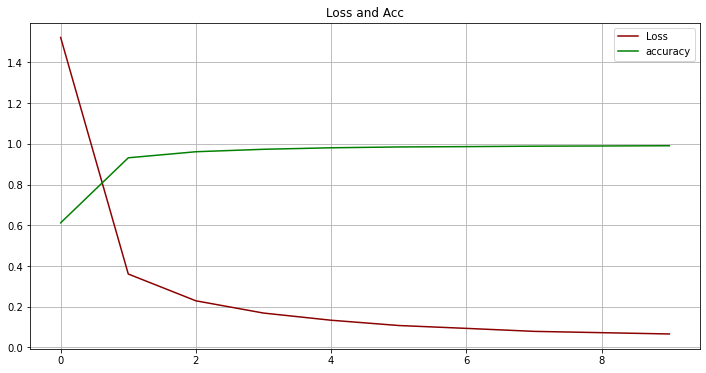

In [46]:
plt.figure(figsize=(12,6))
plt.grid()
plt.title('Loss and Acc')
plt.plot(history.history['loss'], color='darkred', label='Loss')
plt.plot(history.history['accuracy'], color='green', label='accuracy')
plt.legend()

Aplico os mesmos métodos que apliquei no treino.

In [47]:
test_df['MatrixIMG'] = test_df['Path'].apply(lambda x: cv.imread(x))
test_df['MatrixIMG'] = test_df['MatrixIMG'].apply(lambda img: cv.resize(img,(50, 50), interpolation = cv.INTER_CUBIC))
test_df['MatrixIMG'] = test_df['MatrixIMG'].apply(rgb2gray)
test_df['MatrixIMG'] = test_df['MatrixIMG'].apply(lambda x: x/255.0)

In [48]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,MatrixIMG
0,53,54,6,5,48,49,16,Test/00000.png,"[[0.5718654901960785, 0.5711403921568626, 0.56..."
1,42,45,5,5,36,40,1,Test/00001.png,"[[0.2521760784313726, 0.29387647058823524, 0.2..."
2,48,52,6,6,43,47,38,Test/00002.png,"[[0.1520250980392157, 0.1566713725490196, 0.15..."
3,27,29,5,5,22,24,33,Test/00003.png,"[[0.4957462745098039, 0.42985372549019607, 0.3..."
4,60,57,5,5,55,52,11,Test/00004.png,"[[0.13389372549019607, 0.13434078431372548, 0...."


E faço os mesmos passos que fiz nos dados de treino.

In [49]:
X_test = test_df['MatrixIMG']
y_test = test_df[['ClassId']].values

In [50]:
exemplos_test = []

for i in range(len(X_test)):
    exemplos_test.append(X_test[i])

In [51]:
X_test = np.array(exemplos_test)
X_test = X_test.reshape((X_test.shape[0], 50, 50, 1))

In [52]:
y_test = one_hot.fit_transform(y_test)

In [53]:
y_pred = model.predict(X_test)

In [54]:
label = [str(i) for i in range(43)]

Para poder utilizar o classification_report, foi usado a função argmax() com o axis=1, pois assim pegamos as linhas e vemos o índice do maior valor, que no caso é o número 1, e o índice em que se encontra é a classificação.

In [55]:
y_test.argmax(axis=1)

array([16,  1, 38, ...,  6,  7, 10], dtype=int64)

In [56]:
y_pred.argmax(axis=1)

array([16,  1, 38, ...,  3,  7, 10], dtype=int64)

Notemos que a falta de dados influenciou na quantidade de acertos, na classe 27 temos um uma precisão muito baixa fora algumas classes que estão abaixo dos 70% de acerto.

In [57]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=label))

              precision    recall  f1-score   support

           0       1.00      0.72      0.83        60
           1       0.92      0.94      0.93       720
           2       0.98      0.92      0.95       750
           3       0.78      0.97      0.87       450
           4       0.99      0.85      0.91       660
           5       0.90      0.91      0.91       630
           6       0.98      0.78      0.87       150
           7       0.95      0.83      0.88       450
           8       0.81      0.92      0.86       450
           9       0.91      0.97      0.94       480
          10       0.98      0.97      0.97       660
          11       0.74      0.98      0.85       420
          12       0.96      0.97      0.96       690
          13       0.98      0.99      0.98       720
          14       0.99      0.94      0.96       270
          15       0.90      0.98      0.93       210
          16       0.90      0.99      0.94       150
          17       0.96    

Aqui eu comparo a classe verdadeira com a resposta do modelo.

In [58]:
y_test[:10].argmax(axis=1)

array([16,  1, 38, 33, 11, 38, 18, 12, 25, 35], dtype=int64)

In [59]:
y_pred[:10].argmax(axis=1)

array([16,  1, 38, 33, 11, 38, 18, 12, 25, 35], dtype=int64)

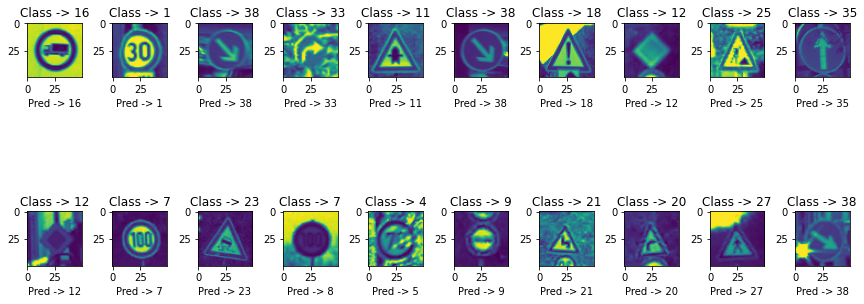

In [60]:
rows = 2
cols = 10
axes = []
fig = plt.figure(figsize=(12,6))

for a in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Class -> "+str(y_test[:20].argmax(axis=1)[a]))
    axes[-1].set_title(subplot_title)
    subplot_xlabel=("Pred -> "+str(y_pred[:20].argmax(axis=1)[a]))
    axes[-1].set_xlabel(subplot_xlabel)
    plt.imshow(X_test[a])
    

fig.tight_layout()

Fiz uma função que passando o path da imagem, ele retorna a classificação dada pelo modelo e o que a placa quer dizer.

Predict = 7 , Speed limit (100km/h)


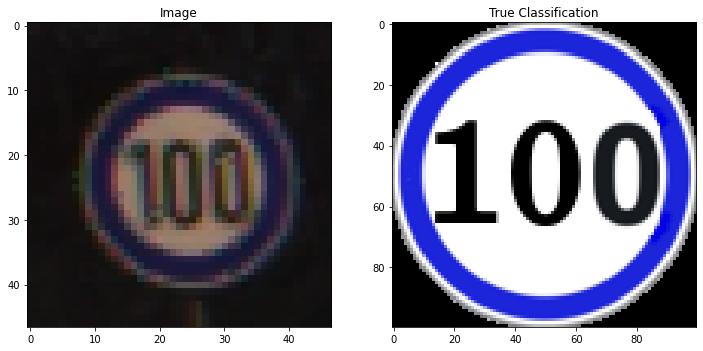

In [63]:
def prediction(path):
    img = cv.imread(path)
    axes = []
    fig = plt.figure(figsize=(12,6))
    
    axes.append( fig.add_subplot(1, 2, 1) )
    subplot_title=("Image")
    axes[-1].set_title(subplot_title)
    plt.imshow(img)
    
    res = rgb2gray(cv.resize(img,(50, 50), interpolation = cv.INTER_CUBIC))
    res = res.reshape(1,50,50,1)/255.0
    
    predict = model.predict(res).argmax()
    
    meta_class = meta_df[meta_df['ClassId'] == predict]['Path'].values[0]
    
    axes.append( fig.add_subplot(1, 2, 2) )
    subplot_title=("True Classification")
    axes[-1].set_title(subplot_title)
    plt.imshow(cv.imread(meta_class))
    
    text_class = labels_df[labels_df['ClassId'] == predict]['SignName'].values[0]
    
    print(f'Predict = {predict} , {text_class}')
    
prediction("Test/11000.png")    

## Solve the problem of unbalanced data

Aqui eu soluciono o problema de desbanlanceamento de dados, tanto no treino, quanto no teste.

In [64]:
from imblearn.over_sampling import SMOTE

Aqui, eu coloco cada instância em um array para podermos ajeitar seu shape, multiplicando 50 por 50.

In [65]:
exemplos = []

for i in range(len(train_df)):
    exemplos.append(train_df['MatrixIMG'][i])

exemplos2 = []

for i in range(len(test_df)):
    exemplos2.append(test_df['MatrixIMG'][i])

In [66]:
train = np.array(exemplos)

In [67]:
train = train.reshape(train.shape[0], -1)

X_smote e y_smote são os dados aumentados para treino e X_test_smote e y_test_smote para o teste, gerando o suficiente para que chegue na quantidade de instâncias da maior classe, no caso são 2250, então cada classe tera 2250 instâncias e após isso, voltamos ao shape original, e o random_state é 42 para que possa ser reproduzido com os mesmos resultados.

In [68]:
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(train, train_df[['ClassId']].values)

In [69]:
X_smote.shape

(96750, 2500)

In [70]:
X_smote = X_smote.reshape(X_smote.shape[0],50,50,1)

In [71]:
X_smote.shape

(96750, 50, 50, 1)

In [72]:
y_smote = y_smote.reshape(y_smote.shape[0],1)

In [73]:
test = np.array(exemplos2)

In [74]:
test = test.reshape(test.shape[0],-1)
X_test_smote, y_test_smote = sm.fit_resample(test, test_df[['ClassId']].values)

In [75]:
y_test_smote = y_test_smote.reshape(y_test_smote.shape[0],1)

In [76]:
X_test_smote = X_test_smote.reshape(X_test_smote.shape[0],50,50,1)

In [77]:
y_smote = one_hot.fit_transform(y_smote)
y_test_smote = one_hot.fit_transform(y_test_smote)

In [78]:
y_smote

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

É necessário rodar novamento o modelo para não utilizar o modelo já treinado

In [81]:
model = tf.keras.models.Sequential([
     
     tf.keras.layers.Conv2D(10, (5,5), padding='same', input_shape=(50,50,1), kernel_initializer="normal", activation='relu', 
                           kernel_regularizer=tf.keras.regularizers.l1(0.01)),
     
     tf.keras.layers.MaxPooling2D((2,2)),
     
     tf.keras.layers.Conv2D(15, (5,5), activation='relu', kernel_initializer="normal"),
     
     tf.keras.layers.MaxPooling2D((2,2)),
     tf.keras.layers.Flatten(),
     
     tf.keras.layers.Dense(100, activation='relu', kernel_initializer="normal"),
     tf.keras.layers.Dense(50, activation='relu', kernel_initializer="normal"),
     tf.keras.layers.Dense(43, activation='softmax')
  
 ])
       
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])     

callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=10, verbose=1, mode="auto") 

In [82]:
history_smoth = model.fit(x=X_smote, y=y_smote, epochs=10, callbacks=[callback])

Epoch 1/10
3024/3024 [==============================] - 79s 26ms/step - loss: 0.6702 - accuracy: 0.8480
Epoch 2/10
3024/3024 [==============================] - 78s 26ms/step - loss: 0.1780 - accuracy: 0.9689
Epoch 3/10
3024/3024 [==============================] - 77s 26ms/step - loss: 0.1096 - accuracy: 0.98120s - loss: 0.1097 - accura
Epoch 4/10
3024/3024 [==============================] - 77s 26ms/step - loss: 0.0766 - accuracy: 0.9872
Epoch 5/10
3024/3024 [==============================] - 78s 26ms/step - loss: 0.0629 - accuracy: 0.9895
Epoch 6/10
3024/3024 [==============================] - 76s 25ms/step - loss: 0.0487 - accuracy: 0.9922
Epoch 7/10
3024/3024 [==============================] - 77s 26ms/step - loss: 0.0441 - accuracy: 0.9928
Epoch 8/10
3024/3024 [==============================] - 78s 26ms/step - loss: 0.0367 - accuracy: 0.9940
Epoch 9/10
3024/3024 [==============================] - 78s 26ms/step - loss: 0.0346 - accuracy: 0.9944
Epoch 10/10
3024/3024 [===============

In [83]:
y_pred_smoth = model.predict(X_test_smote)

In [90]:
y_pred = model.predict(X_test)

Aqui, eu testei a predição do modelo nos dados de teste antes do aumento

In [91]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=label))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87        60
           1       0.94      0.94      0.94       720
           2       0.94      0.94      0.94       750
           3       0.89      0.93      0.91       450
           4       0.92      0.91      0.91       660
           5       0.79      0.88      0.84       630
           6       0.99      0.77      0.86       150
           7       0.97      0.84      0.90       450
           8       0.91      0.91      0.91       450
           9       0.94      0.98      0.96       480
          10       0.98      0.95      0.97       660
          11       0.86      0.92      0.89       420
          12       0.98      0.96      0.97       690
          13       0.93      0.99      0.96       720
          14       0.97      0.99      0.98       270
          15       0.88      0.99      0.93       210
          16       1.00      0.97      0.99       150
          17       0.96    

Aqui, notemos que todas as classes estão acima dos 70%, comprovando que realmente melhorou ter balanceado os dados.

In [92]:
print(classification_report(y_test_smote.argmax(axis=1), y_pred_smoth.argmax(axis=1), target_names=label))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       750
           1       0.93      0.94      0.94       750
           2       0.92      0.94      0.93       750
           3       0.85      0.93      0.89       750
           4       0.86      0.91      0.88       750
           5       0.71      0.89      0.79       750
           6       1.00      0.76      0.87       750
           7       0.98      0.85      0.91       750
           8       0.91      0.92      0.92       750
           9       0.72      0.98      0.83       750
          10       0.97      0.96      0.96       750
          11       0.76      0.93      0.84       750
          12       0.87      0.96      0.92       750
          13       0.90      0.99      0.94       750
          14       0.97      1.00      0.99       750
          15       0.96      0.99      0.97       750
          16       1.00      0.98      0.99       750
          17       0.98    

## Taking images from the internet for model validation

Para que o modelo classifique bem, foi feito um corte em cada imagem para que fique apenas a placa, não consegui resolver este problema.

Predict = 14 , Stop


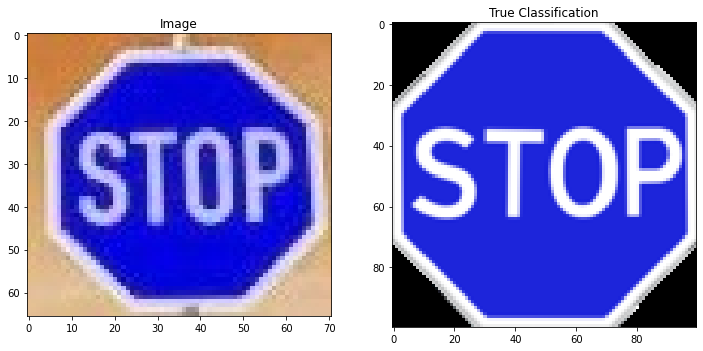

In [85]:
prediction('image_STOP.jpg')

Predict = 18 , General caution


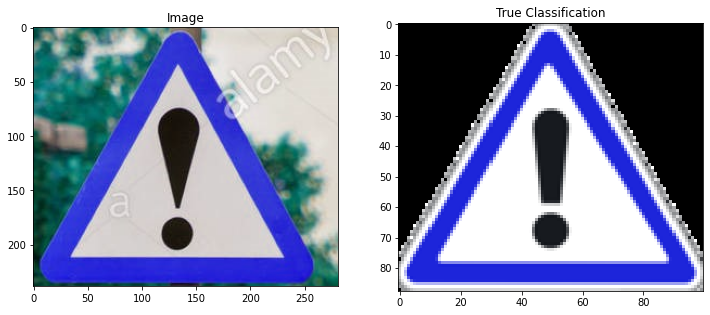

In [100]:
prediction('image1.jpg')

Predict = 33 , Turn right ahead


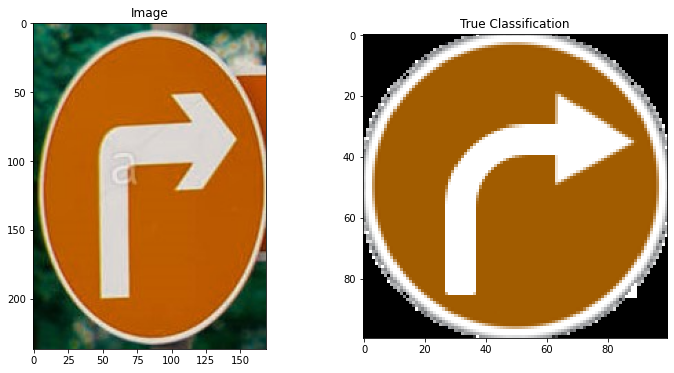

In [101]:
prediction('image2.jpg')

Predict = 35 , Ahead only


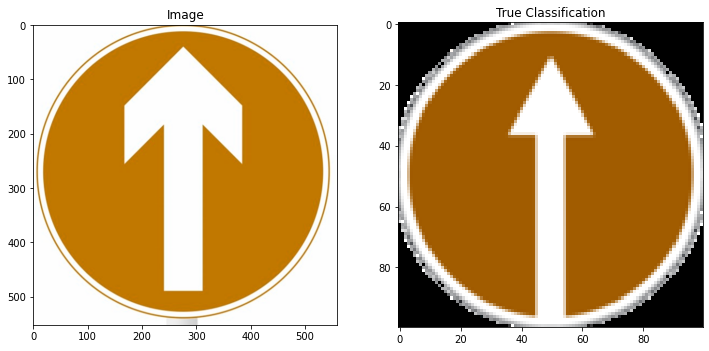

In [102]:
prediction('image3.jpg')

## Saving the model and weights

In [88]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")

## Loading the model and weights

In [96]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")

loaded_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test_smote, y_test_smote, verbose=0)

In [97]:
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 89.17%
